# 使用keras检查肺炎
使用keras构建CNN网络来检查肺炎。  
  
本练习的目的是了解我们创建的神经网络对肺炎患者的 X 射线扫描进行分类的准确性如何。  

## 加载我们需要的库函数。

In [1]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os
from PIL import Image
# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

我们的数据在三个文件夹中：  
train= 包括所有的训练数据，用来训练模型。  
val= 包括用来评估我们模型的图像。这些数据用来防止我们的模型过拟合。过拟合就是我们的模型对于训练数据十分准确，但是新的、未见过的数据不能很好地处理。  
test = 这部分数据用来测试我们训练的模型是否准确。这些数据在模型的训练过程中没有被模型见过，属于新的数据。  

In [2]:
mainDIR = os.listdir('chest_xray_dataset')
print(mainDIR)

['test', 'val', 'train']


## 设置文件夹

In [3]:
train_folder= 'chest_xray_dataset/train/'
val_folder = 'chest_xray_dataset/val/'
test_folder = 'chest_xray_dataset/test/'

In [4]:
# train 
os.listdir(train_folder)
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

## 数据预处理
对于非专业的学生，区分胸片的确非常困难。  
这里我们先看看这些图像的样子。  

1341
normal picture title:  NORMAL2-IM-0478-0001.jpeg
pneumonia picture title: person766_bacteria_2670.jpeg


Text(0.5, 1.0, 'Pneumonia')

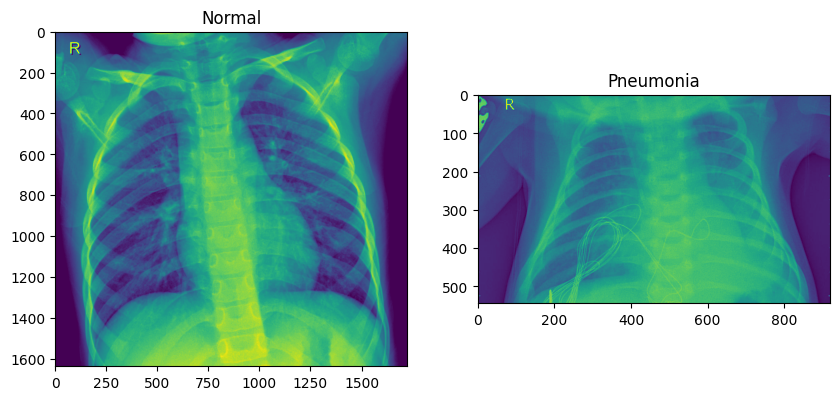

In [5]:
#Normal pic 
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

上面的图片是从数据集中随机生成的。 图片中存在细微差异，但让我们看看我们是否不能创建一个卷积神经网络来创建更客观的度量来量化和分类这些差异。

肺炎患者与正常人的胸腔形状存在一些明显的差异。 （非专业的人员很难区分）  

您有没有想过计算机如何看到以及看到什么？  
答案在于哺乳动物生理学。 我们哺乳动物和几乎所有其他有两只眼睛和发达大脑的动物的观察方式如下：  

从物体反射的光线照射到您的视网膜。  
感官输入被传输到您的大脑。  
大脑在解释输入后，会告诉你它看到了什么。  
另外，请记住，您的家人在那里教您什么是事物。 你知道某个东西是一把雨伞，因为你看着它，有人告诉你这个特定的物体叫做雨伞。  
然后你的大脑就会存储这种关联，你就不必再被教导了。  


计算机学习/观察的方式与我们没有什么不同。 然而，他们需要查看和分析成千上万的图像，然后才能概括并说黄色雨伞与黑色雨伞属于同一类别。 这是因为他们看到的不是图片，而是描述这些图片的像素的数字表示。 所以当我们看到“图片中的东西时，计算机看到的是这个”

![](1*cot55wd6gdoJlovlCw0AAQ.png)

卷积神经网络  
卷积神经网络是一种特殊类型的人工智能实现，它使用称为卷积运算的特殊数学矩阵操作来处理图像数据。  

1. 卷积通过将两个矩阵相乘并产生第三个较小的矩阵来实现此目的。  
2. 网络获取输入图像，并使用过滤器（或内核）创建描述图像的特征图。    
3. 在卷积运算中，我们采用一个滤波器（通常是 2x2 或 3x3 矩阵）并将其在图像矩阵上滑动。   
两个矩阵中的对应数字相乘并相加，产生描述该输入空间的单个数字。 这个过程在整个图像中重复。  
这可以在下面的动画中看到:  

![](1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif)

--------> 这是在 3 维中发生的计算的 2-D 表示。 具体的计算过程如下：

![](1*EuSjHyyDRPAQUdKCKLTgIQ.png)

1. 我们使用不同的过滤器来传递输入，并获取所有特征图，将它们放在一起作为卷积层的最终输出。  
2. 然后，我们将该层的输出传递给非线性激活函数。最常用的是ReLU。  
3. 我们过程的下一步涉及进一步降低数据的维度，这将降低训练该模型所需的计算能力。 这是通过使用池化层来实现的。 最常用的是最大池化，它采用过滤器创建的窗口中的最大值。   
这显着减少了训练时间并保留了重要信息。

![](1*vbfPq-HvBCkAcZhiSTZybg.png)

与 CNN 最常相关的两个词是 stride 和 padding  

步幅：步幅仅表示滤波器在共卷积运算期间移动的量。   
因此，步幅为 1 意味着过滤器将在每次协卷积操作后滑动 1 个像素，如本动画所示。  

![](0*iqNdZWyNeCr5tCkc.gif)

PADDING：填充只是输入图像周围的零值像素。 由于特征图不断缩小，因此可以防止丢失任何有价值的信息。


由于 Keras 等深度学习库，卷积神经网络很容易构建和运行  
1. Keras 是一个高级深度学习库。  
2. 它运行在更底层的库（例如 Tensorflow）之上，这就是您通常会看到该消息的原因。 “使用 TensorFlow 后端。” 当您调用 Keras 时显示。  
3. 我将构建一个具有 2 个卷积层的 CNN。 每次卷积之后，我将使用最大池化添加一个池化层。  
4. 在第二个卷积层之后，我们将添加 2 个全连接层，它们将取出图像的特征图并对其进行预测。 
5. 第二FC只有 1 个单位，因为它需要预测某人是否患有肺炎。  
当我们编译这个 CNN 时，我们将使用 Adam 优化函数来优化我们的模型学习图像正确分类的速度。 优化函数对于我来说太复杂了，无法在这篇文章中讨论。  

## 设计网络
这个网络相对简单：卷积-MAXPOOLING-卷积-MAXPOOLING-全联接-输出

In [6]:
# let's build the CNN model

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))



2023-10-28 21:47:27.600810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 21:47:28.560573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-10-28 21:47:28.561012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10410 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


## 编译网络
这里要注意使用的优化器、损失函数和metrics

In [7]:
# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## 设置必要的超参数

In [8]:
num_of_test_samples = 600
batch_size = 32

## 数据处理

使用ImageDataGenerator-flow_from_directory流水线对数据进行处理。  
一个很好的实践：将训练图像变形：翻转、平移、缩放  
三个部分的数据都要处理  

In [9]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory('chest_xray_dataset/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory('chest_xray_dataset/val/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_set = test_datagen.flow_from_directory('chest_xray_dataset/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## summary()是查看网络模型的API

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

## 模型训练
workers默认为1，本机CPU有12个核，所以这里可以使用12。  
多线程/多进程可以大幅度提升训练的速度。  


In [12]:
cnn_model = cnn.fit(training_set,
                         steps_per_epoch = 163,
                         epochs = 20,
                         validation_data = validation_generator,
                         workers=12,
                         validation_steps = 624,
                         use_multiprocessing=True
                   )

Epoch 1/20
163/163 [==============================] - 73s 448ms/step - loss: 0.1452 - accuracy: 0.9450 - val_loss: 0.4560 - val_accuracy: 0.7500
Epoch 2/20
163/163 [==============================] - 76s 461ms/step - loss: 0.1509 - accuracy: 0.9408 - val_loss: 0.3687 - val_accuracy: 0.8125
Epoch 3/20
163/163 [==============================] - 77s 468ms/step - loss: 0.1341 - accuracy: 0.9473 - val_loss: 1.1147 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 75s 460ms/step - loss: 0.1358 - accuracy: 0.9505 - val_loss: 0.6435 - val_accuracy: 0.6875
Epoch 5/20
163/163 [==============================] - 76s 464ms/step - loss: 0.1316 - accuracy: 0.9515 - val_loss: 0.6236 - val_accuracy: 0.6875
Epoch 6/20
163/163 [==============================] - 76s 463ms/step - loss: 0.1221 - accuracy: 0.9553 - val_loss: 0.3527 - val_accuracy: 0.7500
Epoch 7/20
163/163 [==============================] - 75s 456ms/step - loss: 0.1225 - accuracy: 0.9523 - val_loss: 0.3318 - val_ac

## 查看test数据集数据的最终表现

Test数据集是测试模型性能的标杆。  
Train数据集高，而Test表现不良就是我们所说的<strong>过拟合</strong>

In [13]:
test_loss, test_eval= cnn.evaluate(test_set,steps=624)

624/624 [==============================] - 3s 5ms/step - loss: 0.4275 - accuracy: 0.8846


In [14]:
print('The testing accuracy is :',test_eval*100, '%')

The testing accuracy is : 88.46153616905212 %


In [15]:
Y_pred = cnn.predict(test_set, 100)
y_pred = np.argmax(Y_pred, axis=1)

In [16]:
max(y_pred)

0

In [17]:
import time
t = time.time()

export_path = "saved_models/{}".format(int(t))
cnn.save(export_path)

2023-10-28 22:25:38.095756: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/1698503137/assets


## 将模型保持为h5格式

In [18]:
cnn.save(f'model_{t}.h5')

## 打印出训练模型过程中的训练集的准确率和验证集的准确率

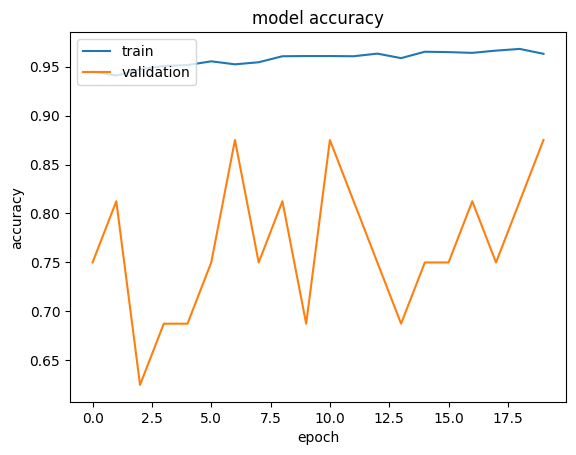

In [19]:
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

## 打印出训练模型过程中的训练集的损失率和验证集的损失率

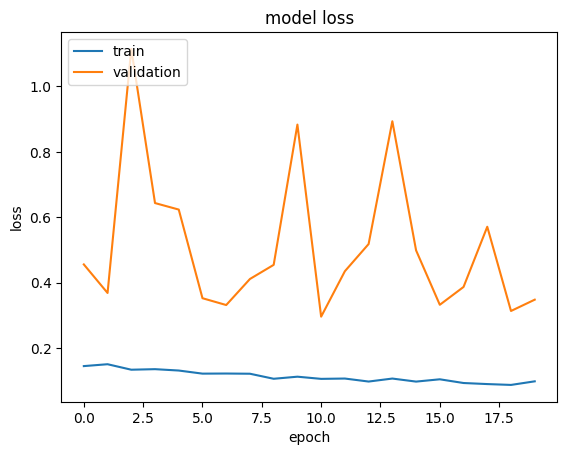

In [20]:
# summarize history for loss
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [22]:
confusion_matrix(validation_generator.classes, y_pred[:16])

array([[8, 0],
       [8, 0]])

# 参考
1. [Keras训练](https://keras.io/api/models/model_training_apis/)
2. [Display Deep Learning Model Training History in Keras](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
3. [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)